In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
from footprint_tune import footprint_maker
import pandas as pd
import glob
from lsst.sims.featureScheduler.utils import standard_goals
import sqlite3


In [2]:
dbfiles = glob.glob('*10yrs.db')
dbfiles.sort()
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)


In [3]:
dbfiles

['baseline_nexp2_v1.7_10yrs.db',
 'footprint_0_v1.710yrs.db',
 'footprint_1_v1.710yrs.db',
 'footprint_2_v1.710yrs.db',
 'footprint_3_v1.710yrs.db',
 'footprint_4_v1.710yrs.db',
 'footprint_5_v1.710yrs.db',
 'footprint_6_v1.710yrs.db',
 'footprint_7_v1.710yrs.db',
 'footprint_8_v1.710yrs.db']

In [4]:
ddf_fracs = []
for filename in dbfiles:
    con = sqlite3.connect(filename)
    q1 = 'select count(night) from summaryallprops where note like "%DD%";'
    q2 = 'select count(night) from summaryallprops ;'
    r1 = pd.read_sql(q1, con)
    r2 = pd.read_sql(q2, con)
    con.close()
    ddf_fracs.append(np.max(r1.values)/np.max(r2.values))

In [5]:
results = []
for dbfile in dbfiles:
    conn = db.OpsimDatabase(dbfile)
    bundleList = []
    sql = ''
    metric = metrics.CountMetric(col='night')
    slicer = slicers.HealpixSlicer()
    summaryStats = [metrics.SumMetric()]
    plotDict = {}
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))
    
    nside=64
    metric = metrics.CountExplimMetric(col='night', metricName='fO')
    summaryMetrics = [metrics.fONv(nside=nside, norm=False, metricName='fONv',
                                     Asky=18000, Nvisit=925)]
    slicer = slicers.HealpixSlicer(nside=nside)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryMetrics))
    
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    results.append(bd)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'night', 'fieldDec', 'visitExposureTime'].
Found 2045493 visits
Running:  ['opsim_Count_night_HEAL']
Completed metric generation.
Running:  ['opsim_fO_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'night', 'fieldDec', 'visitExposureTime'].
Found 2046219 visits
Running:  ['opsim_Count_night_HEAL']
Completed metric generation.
Running:  ['opsim_fO_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Healpix slicer using NSIDE=128, approximate 

In [6]:
nside = 32

unextinct = footprint_maker(8)
ue_wfd = np.where(unextinct['r'] == 1)[0]

wfd_areas= {}
wfd_ue_areas = {}

wfd_fracs = {}

descr = {9: 'Classic Baseline',
        0: 'Default',
        1: 'No north stripe',
        2: 'No north, shrink wfd a little',
        3: 'Extend bridge south',
        4: 'WFD 3.6 to -62.5, even bigger bridge',
        5: 'WFD 8 to -67.4, bridge like #3',
        6: 'like 5, shift bridge a little',
        7: 'No north, no South Ecliptic',
        8: 'WFD all dust free'}


for i in descr:
    if i == 9:
        fp = standard_goals()
    else:
        fp = footprint_maker(i)
    wfd=np.where(fp['r'] == 1)[0]
    wfd_area = wfd.size * hp.nside2pixarea(nside, degrees=True)
    wfd_areas[i] = wfd_area
    
    wfd_ue = np.where((unextinct['r'] == 1) & (fp['r'] == 1))[0]
    ue_area = wfd_ue.size * hp.nside2pixarea(nside, degrees=True)
    wfd_ue_areas[i] = ue_area
    
    total = 0
    wfd_sum = 0
    for key in fp:
        total += np.sum(fp[key])
        wfd_sum += np.sum(fp[key][wfd])
        
    wfd_fracs[i] = wfd_sum/total * (1.-ddf_fracs[i])
    #hp.mollview(fp['r'], title="%i, %.1f, %.1f" % (i, wfd_area, ue_area))

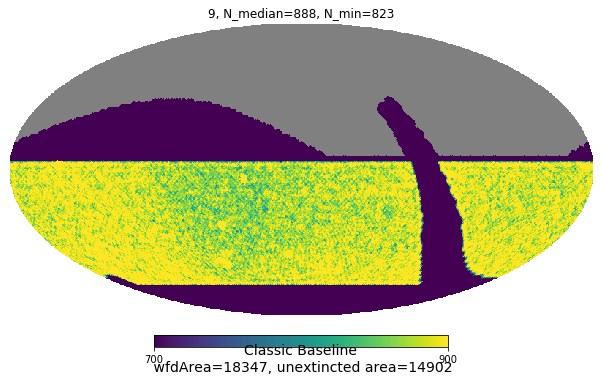

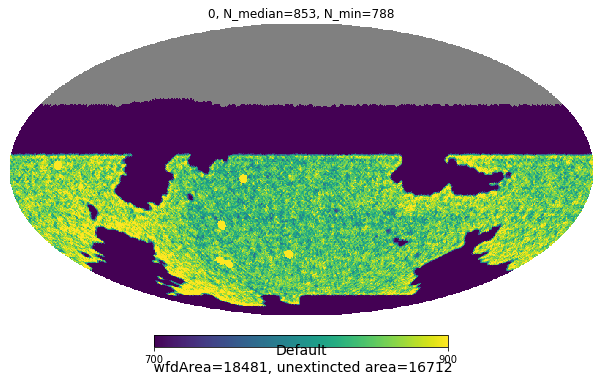

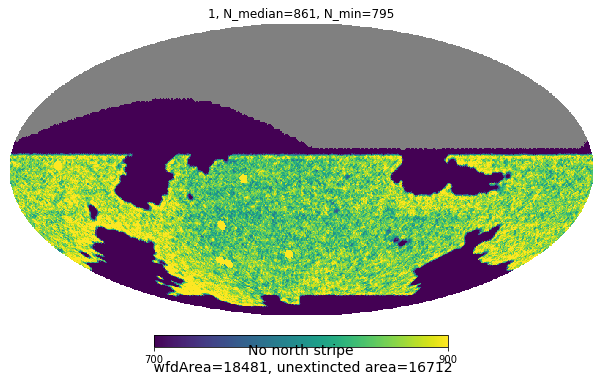

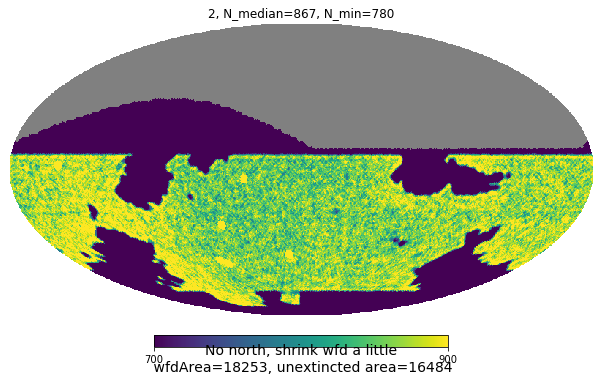

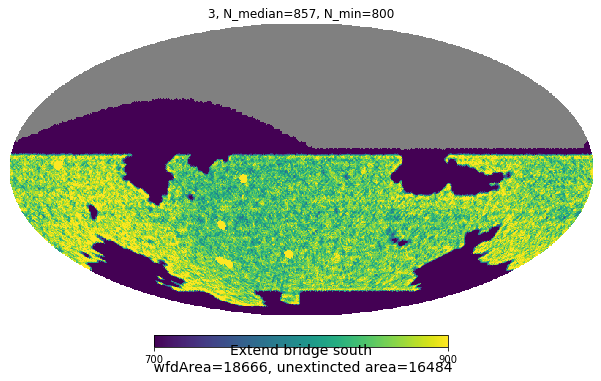

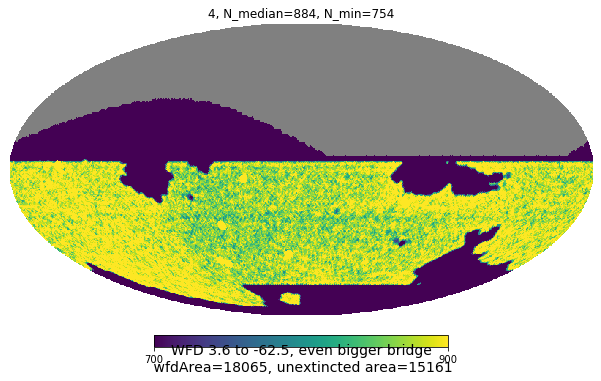

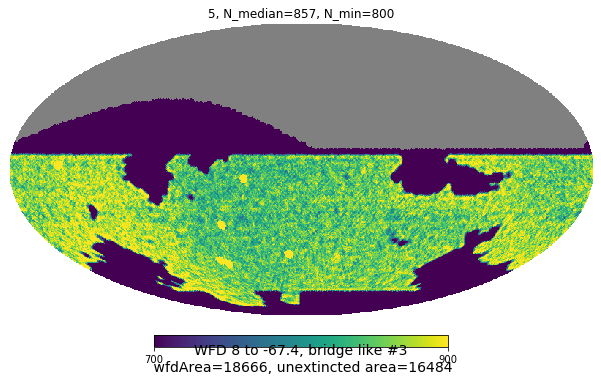

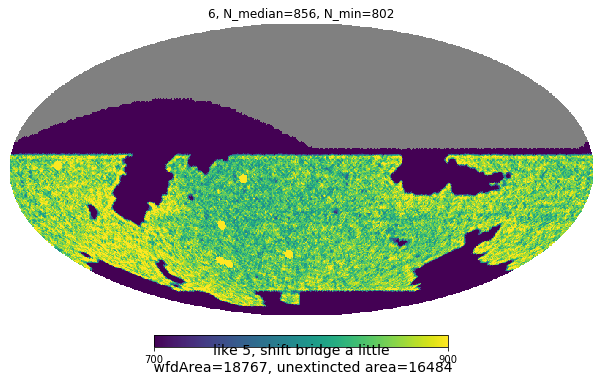

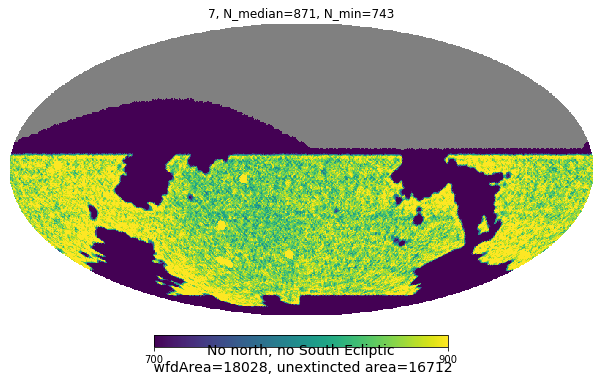

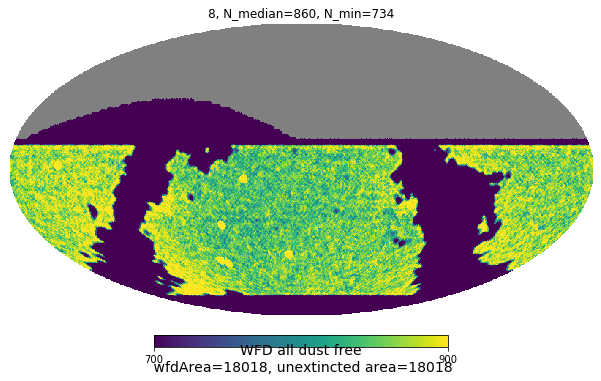

In [8]:



names = ['fpid', 'N_median', 'M_min', 'WFD_area', 'WFD_unex_area', 'WFD_frac_attempted', 'DDF_frac', 'Desc']
types = [int, int, int, float, float, float, float, '|U100']
table_arr = np.zeros(len(results), dtype=list(zip(names, types)))

for fn,bd in zip(dbfiles, results):
    if 'baseline' in fn:
        fpid = '9'
    else:
        fpid = fn.split('_')[1]
    hp.mollview(bd['opsim_Count_night_HEAL'].metricValues, max=900, min=700,
                title=fpid+', N_median=%i, N_min=%i' % (bd['opsim_fO_HEAL'].summaryValues['fONv'][0][1],
                                       bd['opsim_fO_HEAL'].summaryValues['fONv'][1][1]),
               unit=descr[int(fpid)]+'\n wfdArea=%.0f, unextincted area=%.0f' % (wfd_areas[int(fpid)], wfd_ue_areas[int(fpid)]))
    fpid = int(fpid)
    table_arr[fpid]['fpid'] = fpid
    table_arr[fpid]['N_median'] = bd['opsim_fO_HEAL'].summaryValues['fONv'][0][1]
    table_arr[fpid]['M_min'] =  bd['opsim_fO_HEAL'].summaryValues['fONv'][1][1]
    table_arr[fpid]['WFD_area'] = wfd_areas[int(fpid)]
    table_arr[fpid]['WFD_unex_area'] = wfd_ue_areas[int(fpid)]
    table_arr[fpid]['Desc'] = descr[int(fpid)]
    table_arr[fpid]['WFD_frac_attempted'] = wfd_fracs[int(fpid)]
    table_arr[fpid]['DDF_frac'] = ddf_fracs[int(fpid)]

In [ ]:
# let's also look at the footprints and see 

In [9]:
df = pd.DataFrame(table_arr)


In [10]:
df
    

,fpid,N_median,M_min,WFD_area,WFD_unex_area,WFD_frac_attempted,DDF_frac,Desc
0,0,853,788,18481.246068,16712.015063,0.838773,0.045694,Default
1,1,861,795,18481.246068,16712.015063,0.842404,0.045555,No north stripe
2,2,867,780,18252.958196,16483.727192,0.838498,0.045682,"No north, shrink wfd a little"
3,3,857,800,18665.890669,16483.727192,0.845381,0.045632,Extend bridge south
4,4,884,754,18064.956420,15161.000407,0.841109,0.045520,"WFD 3.6 to -62.5, even bigger bridge"
5,5,857,800,18665.890669,16483.727192,0.845355,0.045661,"WFD 8 to -67.4, bridge like #3"
6,6,856,802,18766.605907,16483.727192,0.847096,0.045520,"like 5, shift bridge a little"
7,7,871,743,18028.027499,16712.015063,0.834639,0.045752,"No north, no South Ecliptic"
8,8,860,734,18017.955975,18017.955975,0.825646,0.045718,WFD all dust free
9,9,888,823,18346.959084,14902.497964,0.857104,0.045660,Classic Baseline
